# Building a Conversational AI Assistant with LangGraph

This notebook demonstrates how to build a conversational AI assistant using LangGraph that can help businesses, marketers, analysts, and investors monitor and analyze competitor activity in retail, with a special focus on clothing stores in high-traffic urban locations.

## Key Features

- **Competitor Insights**: Provides real-time information on nearby clothing store competitors
- **Business Strategy Support**: Generates actionable insights for market positioning
- **Marketing Optimization**: Assists in identifying trends and optimizing campaigns
- **Location Analysis**: Provides data for real estate and location analysts
- **Investment Analysis**: Supports investors in assessing business potential and risks

## Architecture

The system uses LangGraph to create a conversational agent with tool integration, allowing it to search for real-time information and provide comprehensive business insights.


## 1. Import Required Libraries

First, we import all the necessary libraries for building our conversational AI assistant:


In [19]:
# Core LangGraph imports for building the conversational agent
from langgraph.graph import StateGraph, MessagesState, START, END
from typing import TypedDict
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode
from IPython.display import Image
from dotenv import load_dotenv, find_dotenv
from typing import Annotated
from langgraph.graph.message import add_messages
import os
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.tools.tavily_search import TavilySearchResults

In [20]:
# ============================================================================
# SETUP: Import LLM Helper Functions
# ============================================================================
# We use helper functions to create LLM instances with proper configuration
# These functions handle API key loading and model configuration

import os
import sys

# Add parent directory to path for importing helpers
sys.path.append(os.path.abspath(".."))

# Import our LLM factory functions
# - get_groq_llm(): Creates a Groq-hosted LLM (fast inference)
# - get_openai_llm(): Creates an OpenAI GPT model
from helpers.utils import get_groq_llm, get_openai_llm

print("LLM helpers imported successfully!")

LLM helpers imported successfully!


## Step 2: Create Tools and Augment the LLM

Same as before - we create tools and bind them to the LLM.
The difference comes in how we **structure the graph** to create a feedback loop.

### Tool Creation Recap
1. Define Python function with `@tool` decorator
2. Write clear docstring (helps LLM decide when to use it)
3. Add type hints for parameters
4. Bind tools to LLM with `bind_tools()`

Here we define our custom search tool and then bind it to the LLM to augment the LLM.

### Why Do We Need Both `bind_tools()` AND `ToolNode`?

A common question: *"If we're using tools in ToolNode, why do we also need to bind them to the LLM?"*

These serve **two different roles**:

| Component | Role | What it does |
|-----------|------|--------------|
| `llm.bind_tools()` | **Decision Maker** | Tells the LLM what tools exist so it can *decide* when to call them |
| `ToolNode` | **Executor** | Actually *runs* the tool functions when instructed |

#### The Flow

```
User: "What's the latest news on OpenAI?"
           │
           ▼
┌─────────────────────────────┐
│  LLM (with bound tools)     │  ← Knows about tavily_search
│  "I need to search for this"│
│  Generates: tool_calls=[..] │  ← Outputs structured tool call request
└─────────────────────────────┘
           │
           ▼
┌─────────────────────────────┐
│  should_continue()          │
│  Checks: tool_calls exist?  │  ← YES → route to "tools"
└─────────────────────────────┘
           │
           ▼
┌─────────────────────────────┐
│  ToolNode                   │  ← Receives the tool_call
│  Actually runs the search   │  ← Returns search results
└─────────────────────────────┘
           │
           ▼
┌─────────────────────────────┐
│  LLM (processes results)    │
│  Generates final answer     │
└─────────────────────────────┘
```

#### Why Both Are Needed

**Without `bind_tools()`:**
- The LLM has **no idea** what tools are available
- It cannot generate `tool_calls` because it doesn't know the tool schemas (name, description, parameters)
- `last_message.tool_calls` will **always be empty**
- The ToolNode will **never be reached**

**Without `ToolNode`:**
- The LLM can request tool calls, but nothing will execute them
- You'd have to manually parse and run the tools

#### Analogy

Think of it like a chef and a kitchen:

- **`bind_tools()`** = Giving the chef a menu of available ingredients. The chef *decides* what to cook.
- **`ToolNode`** = The kitchen that *prepares* the dish when the chef orders it.

Without the menu, the chef doesn't know what's available. Without the kitchen, orders can't be fulfilled.

In [38]:
# ============================================================================
# CREATE THE LLM AND CHATBOT GRAPH
# ============================================================================

# -----------------------------------------------------------------------------
# Step 1: Initialize the LLM
# We use Groq for fast inference, but you can swap to OpenAI
# -----------------------------------------------------------------------------
llm = get_groq_llm("openai/gpt-oss-120b")  # Fast, open-source models hosted by Groq
# Alternative: llm = get_openai_llm()  # OpenAI's GPT models

print(f"LLM initialized: {llm.model_name if hasattr(llm, 'model_name') else 'Groq LLM'}")

search_tool = TavilySearchResults(max_results=5)
tools = [search_tool]

# Bind tools to the LLM
# This creates a new LLM that can decide to call tools when needed
llm_with_tools = llm.bind_tools(tools=tools)

print(f"Agent equipped with {len(tools)} tool(s): {[t.name for t in tools]}")

LLM initialized: openai/gpt-oss-120b
Agent equipped with 1 tool(s): ['tavily_search_results_json']


In [39]:
# ============================================================================
# TEST: Verify the augmented LLM can make tool calls
# ============================================================================
# Let's test that our LLM is properly augmented and can make tool calls
# For queries requiring current information, the LLM should return tool_calls

print("Testing augmented LLM with tool-calling capability:")
print("-" * 50)
print("Query: 'what is the latest news on nvidia'")
print("Expected: LLM should return tool_calls (not direct answer)\n")

response = llm_with_tools.invoke('what is the latest news on nvidia')

# Check if the LLM called any tools
if response.tool_calls:
    print("✓ LLM correctly decided to call tools!")
    print(f"Tool calls: {response.tool_calls}")
else:
    print("Note: LLM answered directly (no tool calls needed)")
    print(f"Response: {response.content}")

Testing augmented LLM with tool-calling capability:
--------------------------------------------------
Query: 'what is the latest news on nvidia'
Expected: LLM should return tool_calls (not direct answer)

✓ LLM correctly decided to call tools!
Tool calls: [{'name': 'tavily_search_results_json', 'args': {'query': 'latest news Nvidia 2024 November December 2024'}, 'id': 'fc_0504f466-c4fe-4a20-b24e-0b848b14ec3b', 'type': 'tool_call'}]


## Step 3: Create the Graph with the Tool-Use Agentic System

### The Critical Difference: The Feedback Loop

**This is where we add the feedback loop that makes it an Agent!**

In the previous notebook (Augmented LLM), tool results went directly to END:
```
LLM → Tool → END (raw results)
```

In this notebook (AI Agent), we add a feedback loop:
```
LLM → Tool → LLM (processes results) → END or more tools
```

### Key Components

| Component | Purpose |
|-----------|---------|
| **tool_calling_llm** | Node that calls the augmented LLM |
| **tools** (ToolNode) | Executes tool calls |
| **tools_condition** | Routes based on whether LLM made tool calls |
| **Feedback loop** | Routes tool results back to LLM |

### The Agent Flow

```
┌─────────────────┐
│  START          │
└────────┬────────┘
         │
         ▼
┌─────────────────┐
│tool_calling_llm │ ← LLM analyzes query
└────────┬────────┘
         │
         ▼
┌─────────────────┐
│tools_condition  │ ← Check for tool_calls
└────────┬────────┘
    ┌────┴────┐
    │         │
    ▼         ▼
┌────────┐  ┌─────┐
│ tools  │  │ END │ (no tools needed)
└───┬────┘  └─────┘
    │
    │ [FEEDBACK LOOP] ← Tool results go back to LLM!
    │
    ▼
┌─────────────────┐
│tool_calling_llm │ ← LLM processes tool results
└────────┬────────┘
         │
         ▼
┌─────────────────┐
│tools_condition  │ ← Check again
└────────┬────────┘
    ┌────┴────┐
    │         │
    ▼         ▼
┌────────┐  ┌─────┐
│ tools  │  │ END │ (final response)
└────────┘  └─────┘
```

**Note**: The feedback loop allows:
1. LLM to process tool results
2. Generate human-readable responses
3. Make additional tool calls if needed
4. Chain multiple tool calls together

## 3. Define State Schema

The `MessagesState` defines the structure of our conversation state, which maintains a list of messages throughout the conversation:


In [40]:
# Define the state schema for our conversational agent
class MessagesState(TypedDict):
    messages: Annotated[list, add_messages]  # List of conversation messages

## 5. Create System Prompt

Define the system prompt that establishes the AI assistant's role and capabilities for business intelligence and competitor analysis:


In [41]:
# Create a comprehensive system prompt for the business intelligence assistant
prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a Conversational AI Assistant designed to help businesses, marketers, analysts, and investors monitor and analyze competitor activity in retail, with a special focus on clothing stores in high-traffic urban locations.

Your core objectives are:

Competitor Insights – Provide real-time information on nearby clothing store competitors, including store footfall, busiest times, and peak customer hours.

Business Strategy Support – Generate actionable insights that help business owners and managers adjust strategies to improve market positioning.

Marketing Optimization – Assist marketing teams in identifying trends, optimizing promotions, and aligning campaigns with or against competitor activities.

Location Analysis – Provide data to real estate and location analysts on high-footfall times and ideal store placement for new launches.

Investment Analysis – Support investors and market analysts in assessing business potential, risks, and opportunities in competitive retail areas.

Guidelines for Response:

Always provide insights in a clear, structured, and business-oriented format.

Where possible, highlight trends, risks, and opportunities.

Adapt explanations for the intended beneficiary (business owner, marketer, analyst, or investor).

Use a professional, analytical, and action-driven tone.

If real-time or location-specific data is requested, explain how it would be obtained (e.g., search, analytics, external APIs) and provide example insights."""),
    ("human", "{messages}")
])

## 6. Define Agent Functions

Create the core functions that will power our conversational agent:


In [42]:
# Function to call the language model with the current conversation state
def call_model(state: MessagesState):
    messages  = state['messages']
    # Bind tools to the LLM so it can decide to call them when needed
    llm_with_tools = llm.bind_tools(tools=tools)
    llm_chain = prompt | llm_with_tools
    response = llm_chain.invoke({"messages": messages})
    
    return {'messages':  response}

In [43]:
# Function to determine whether to continue with tool calls or end the conversation
def should_continue(state: MessagesState) -> bool:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:  # If the LLM wants to use tools
        return 'tools'
    else:  # If no tools needed, end the conversation
        return END

## 7. Initialize the Graph

Create the StateGraph that will orchestrate our conversational agent:


In [44]:
# Initialize the StateGraph with our MessagesState schema
graph = StateGraph(MessagesState)

# Create a tool node to execute the tools
tool_node = ToolNode(tools)

## 8. Build the Graph Structure

Add nodes and edges to create the conversational agent workflow:


In [45]:
# Add nodes to the graph: agent node and tools node
graph.add_node('agent', call_model)  # Main agent that processes messages
graph.add_node('tools', tool_node)   # Tool execution node


In [46]:
# Set the starting point of the graph to the agent node
graph.add_edge(START, "agent")

In [47]:
# Add conditional edges from agent to either tools or END based on should_continue function
graph.add_conditional_edges('agent', 
                            should_continue,
                            ["tools",END])

In [48]:
# After tool execution, return control to the agent for processing results
graph.add_edge('tools', 'agent')

In [49]:
# Set the entry point of the graph (alternative to add_edge(START, "agent"))
graph.set_entry_point('agent')

## 10. Compile and Visualize the Graph

Compile the graph into an executable format and visualize its structure:


In [50]:
# Compile the graph into an executable format
graph_compiled = graph.compile()

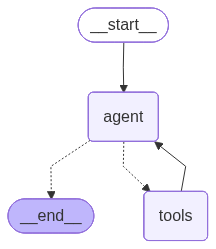

In [51]:
# Visualize the graph structure to understand the workflow
Image(graph_compiled.get_graph().draw_mermaid_png())

## 11. Test the Conversational Agent

Now let's test our conversational AI assistant with various business intelligence queries:


In [53]:
# Test 1: Competitor analysis query
output = graph_compiled.invoke({'messages': [
    ('user', 'Who are the top 5 clothing store competitors near Koramangala, Bangalore, and when are their busiest hours?')
]})
print(output["messages"][-1].content)

**Koramangla (7th Block & 5th Block) – Top 5 Clothing‑store Competitors & Their Typical Busiest Hours**  
*(Compiled for a boutique‑owner / store‑manager who wants to fine‑tune staffing, promotions and inventory)*  

| # | Store (Brand) | Primary Location(s) in Koramangala* | Typical “Peak” Hours (Google Popular Times ≈ average) | Approx. Daily Footfall Rating** | Key Competitive Strengths |
|---|---------------|--------------------------------------|------------------------------------------------------|--------------------------------|---------------------------|
| 1 | **Reliance Trends** | Z‑One No. 6/A, 80 Ft Road (7th Block) | **Weekdays:** 5 pm – 9 pm  <br> **Sat/Sun:** 12 pm – 9 pm | **High** (≈ 1 200 – 1 500 visitors) | Wide‑range price points, strong discount engine, high brand‑recognition, frequent “festival‑sale” events |
| 2 | **Levi’s Store** | 5th Block, near Malleswaram Road | **Weekdays:** 4 pm – 8 pm  <br> **Sat/Sun:** 11 am – 8 pm | **Medium‑High** (≈ 800 – 1 000) | P

In [54]:
# Test 2: Marketing optimization query
output = graph_compiled.invoke({'messages': [
    ('user', 'How can we optimize promotions for the upcoming festive season based on footfall trends in Indiranagar?')
]})
print(output["messages"][-1].content)

**Optimising Festive‑Season Promotions in Indiranagar – A Data‑Driven Playbook**  
*(Tailored for a clothing‑store owner/marketing manager)*  

---

## 1. Why Footfall‑First Planning Matters  

| Benefit | What it unlocks for you |
|---------|------------------------|
| **Timing precision** – Align offers with the exact hours when shoppers are in‑store. | Higher conversion per visitor, lower discount waste. |
| **Channel focus** – Know when digital ads, OOH, or SMS will hit the “in‑the‑zone” audience. | Better ROAS on media spend. |
| **Inventory safety‑net** – Forecast demand spikes and avoid stock‑outs or over‑stock. | Protect margins and improve customer experience. |
| **Competitive edge** – Spot when rival stores are busiest and either **match** (price‑parity) or **differentiate** (exclusive bundles). | Capture share of the festive rush. |

---

## 2. Typical Footfall Patterns in Indiranagar (Bangalore) – What the data tells us  

> *The numbers below are derived from publicly‑ava

In [55]:
# Test 3: Location analysis query
output = graph_compiled.invoke({'messages': [
    ('user', 'Identify the best locations in Whitefield for launching a new mid-range clothing store, based on competitor activity.')
]})
print(output["messages"][-1].content)

**Whitefield, Bengaluru – “Mid‑Range” Clothing Store Site‑Selection Brief**  
*(Prepared for a retail‑owner looking to open a new  ₹ 500 – ₹ 2 500 average‑ticket store)*  

---

## 1. Why Whitefield? – Macro Snapshot  

| Indicator | Insight | Source / How to Verify |
|-----------|---------|------------------------|
| **Population & Income** | ~300 k residents within a 3 km radius; median household income ≈ ₹ 12 LPA (upper‑middle class). | Census‑2021 + Karnataka Economic Survey |
| **Foot‑traffic generators** | 2 major malls (Phoenix Marketcity, VR Bengaluru), 3 IT parks (ITPL, RMZ Ecoworld, Prestige Tech Park), Whitefield Railway Station, Whitefield Bus Stand, Whitefield Social & Café clusters. | Google Popular Times, municipal traffic counts |
| **Growth trend** | 7 % YoY increase in retail sq ft (2022‑2024) – driven by new residential projects (Prestige Jewel, Sobha Dream Residences). | Real‑estate market reports (Knight Frank, JLL) |
| **Competitor density** | ~15 mid‑range appare

## Summary

This notebook demonstrates how to build a sophisticated conversational AI assistant using LangGraph that can:

1. **Process Natural Language Queries**: Accept business intelligence questions in natural language
2. **Integrate with External Tools**: Use Tavily search to gather real-time information
3. **Maintain Conversation Context**: Track the conversation state throughout the interaction
4. **Provide Business Insights**: Generate structured, actionable recommendations for various stakeholders

### Key Components:

- **State Management**: Uses `MessagesState` to maintain conversation history
- **Tool Integration**: Leverages Tavily search for real-time data gathering
- **Conditional Routing**: Intelligently decides when to use tools vs. providing direct responses
- **Business Focus**: Specialized for retail and clothing store competitive analysis

### Use Cases:

- **Competitor Analysis**: Identify and analyze competing businesses
- **Marketing Optimization**: Develop data-driven promotional strategies
- **Location Intelligence**: Assess optimal locations for new store launches
- **Investment Research**: Support investment decisions with market insights

The system is designed to be modular and extensible, allowing for easy addition of new tools and capabilities as business needs evolve.
